**Метрика качества**

Нормализованный коэффициент Gini.

### \begin{equation} Gini_{coef}=2 * ROC~AUC - 1\end{equation}

**Описание**

Цель - предсказать вероятность продления автостраховки.

В обучающейм и тестовом наборе похожие, аналогичные признаки объединены в группы и помечаются как таковые в названии признака(например, ind, reg, car, calc). Кроме того, признаки включающие в названии постфикс "_bin"  являются бинарными и "_cat" - категориальными. Переменные без этих обозначений являются либо количественными, либо порядковыми.  Значения -1 указывают на пропущенное значение.  Целевые столбцы показывают, был ли подан иск для этого держателя полиса.

Целевая переменная содержит информацию о том, продлил ли данный клиент автостраховку или нет(0, 1).

In [49]:
# Импортирование библиотек
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import RFECV
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme(palette=sns.color_palette("viridis"))

In [50]:
# Загружаем данные
train = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\porto-seguro-safe-driver-prediction\\train.csv')
test = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\porto-seguro-safe-driver-prediction\\test.csv')
sub_sample = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\porto-seguro-safe-driver-prediction\\sample_submission.csv')

In [51]:
# Размеры наборов данных
print('Тренировочный набор - {}'.format(train.shape))
print('Тестовый набор - {}'.format(test.shape))

Тренировочный набор - (595212, 59)
Тестовый набор - (892816, 58)


In [52]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [53]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1


In [54]:
# Первичная информация - Типы данных, пропуски не отмеченные как "-1".
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [55]:
# Выделяем признаки и целевую переменную
target = train.target
features = train.drop(['id', 'target'], axis=1)

In [56]:
# Описательная статистика
features.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.610991,0.439184,0.551102,8.295933,0.829931,-0.504899,0.725192,-0.157732,6.555340,0.910027,0.832080,1.328890,0.992136,62.215674,2.346072,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.287643,0.404264,0.793506,2.508270,0.375716,0.788654,2.153463,0.844417,5.501445,0.347106,0.373796,0.978747,0.091619,33.012455,0.832548,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.720677,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000

In [57]:
# Количество дубликатов
features.duplicated().sum()

0

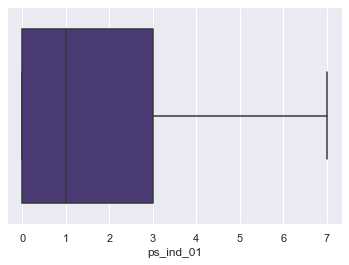

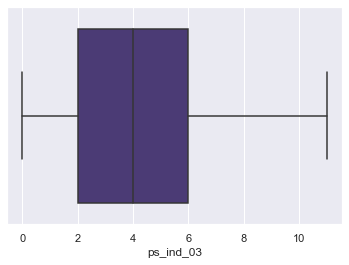

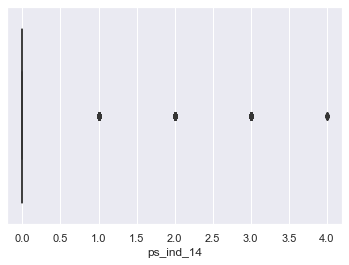

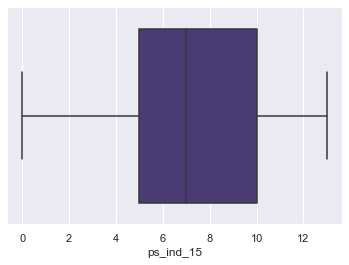

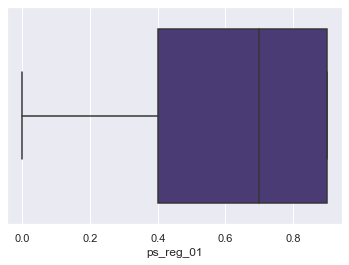

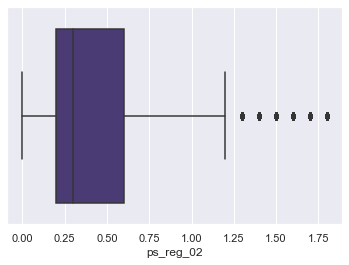

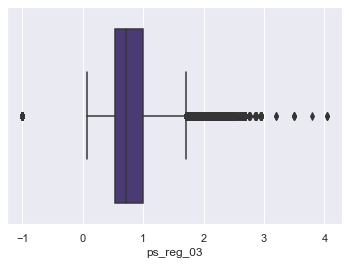

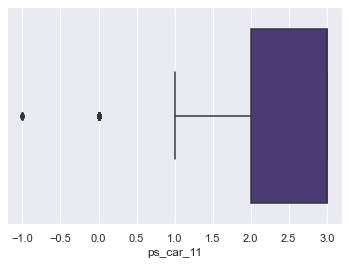

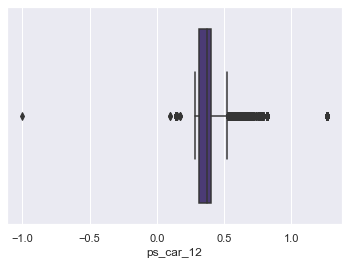

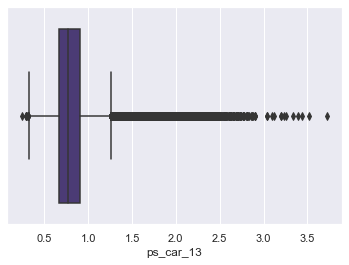

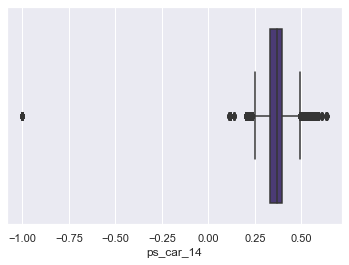

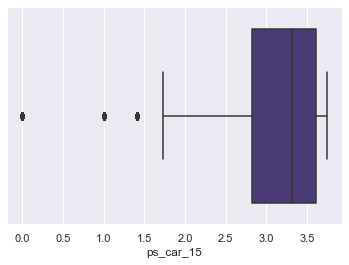

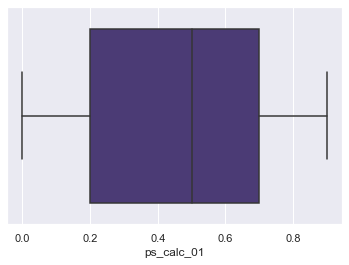

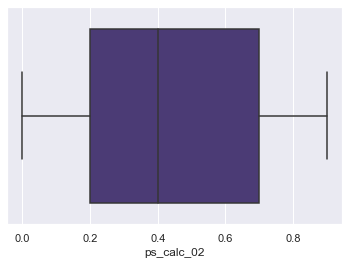

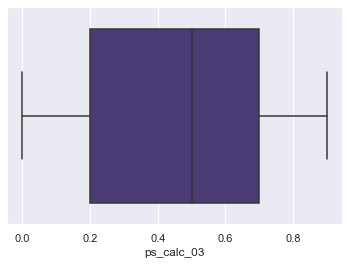

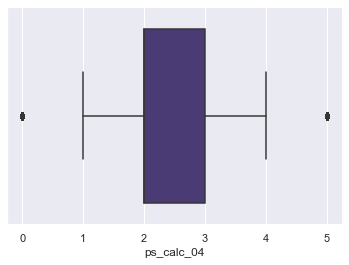

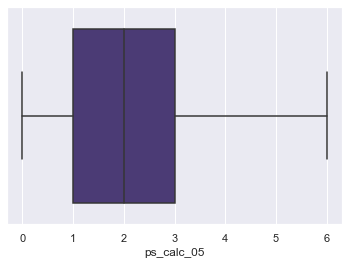

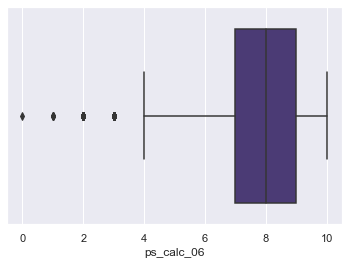

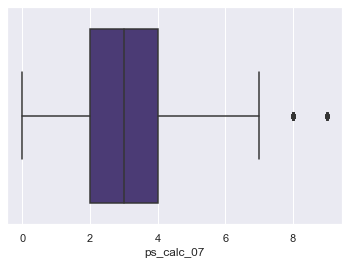

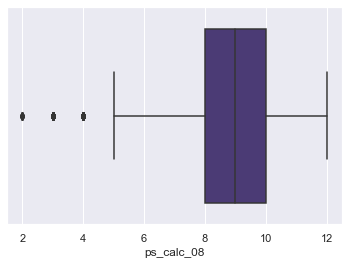

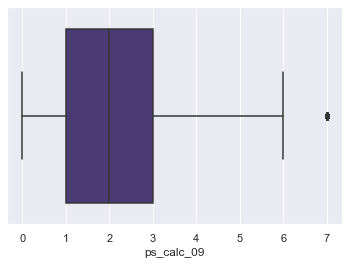

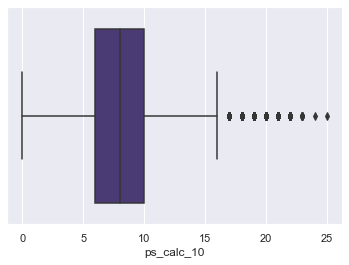

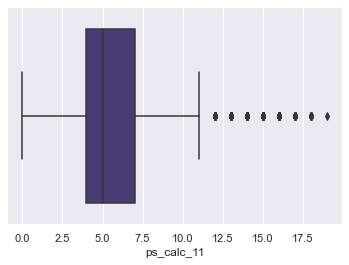

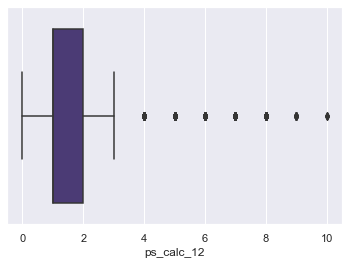

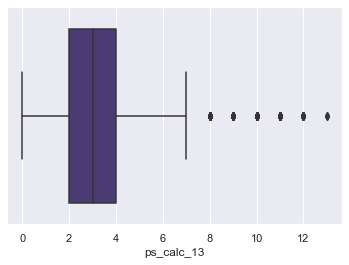

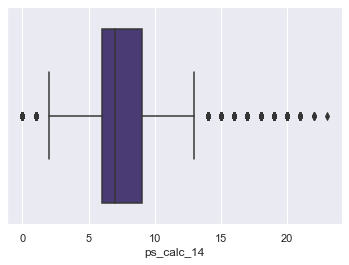

In [58]:
# Выбросы
for feature in features.columns:
    if '_bin' not in feature and '_cat' not in feature:
        plt.figure()
        sns.boxplot(features[feature])

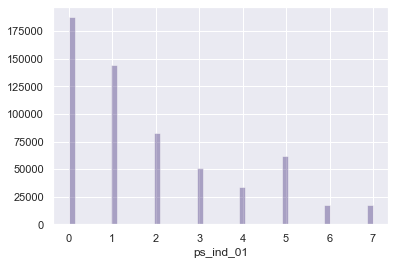

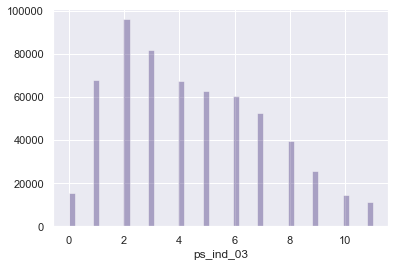

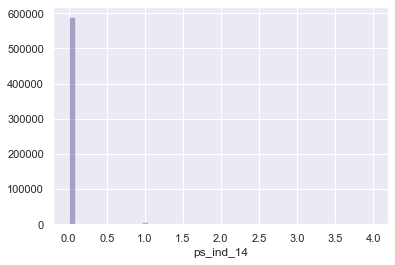

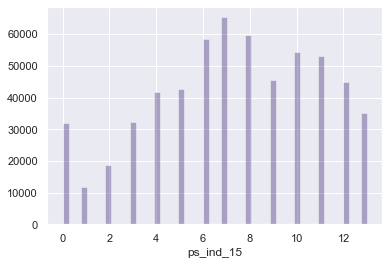

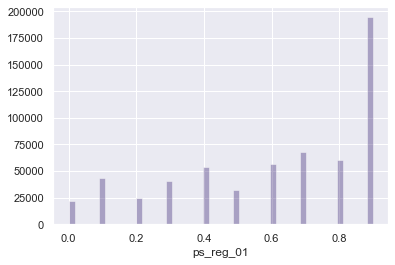

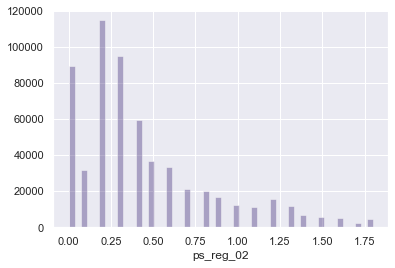

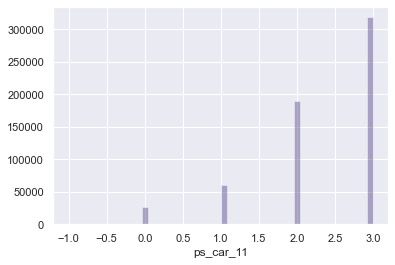

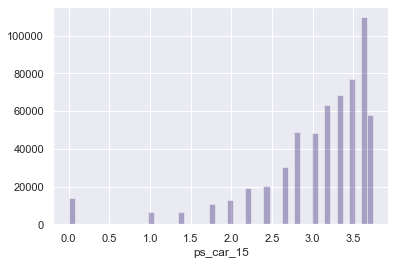

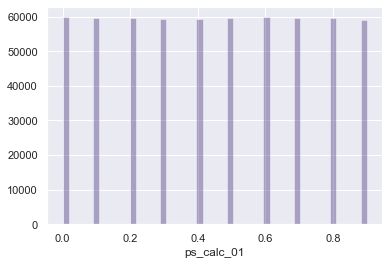

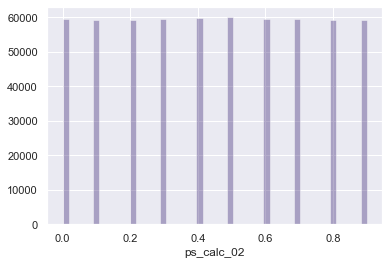

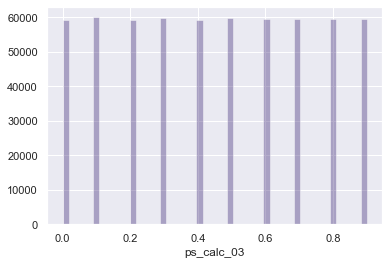

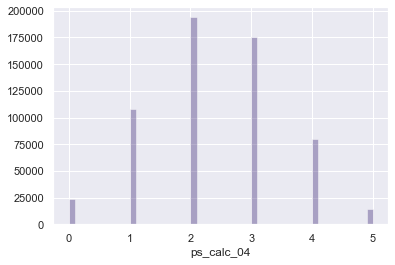

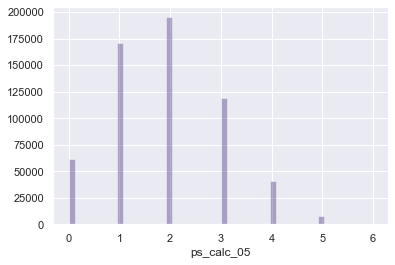

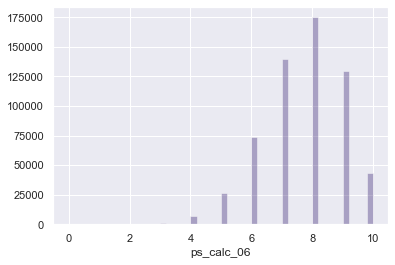

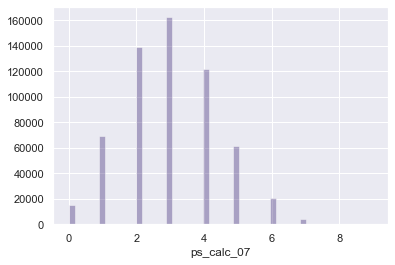

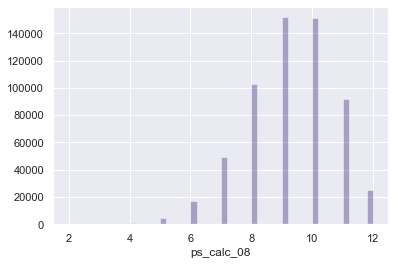

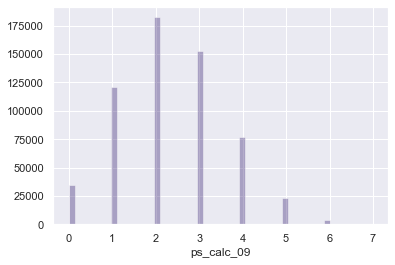

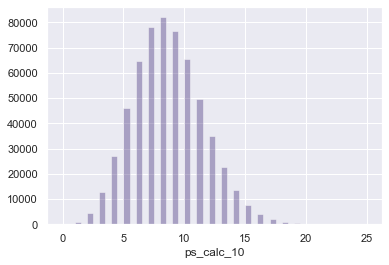

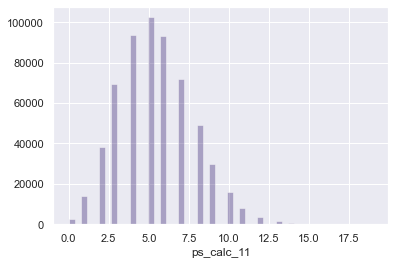

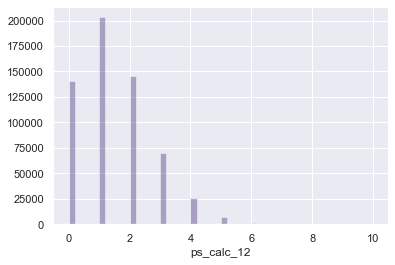

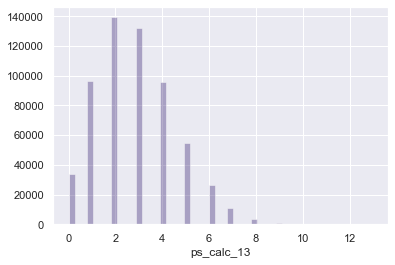

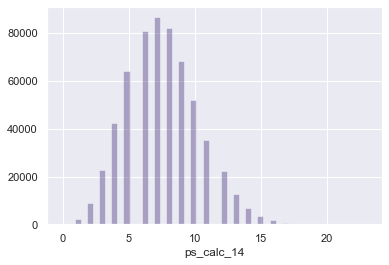

In [59]:
# Порядковые признаки
for feature in features.columns:
    if '_bin' not in feature and '_cat' not in feature and feature not in ['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']:
        plt.figure()
        sns.distplot(features[feature], kde=False)

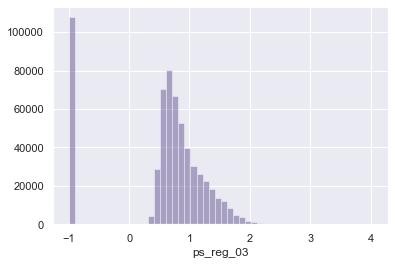

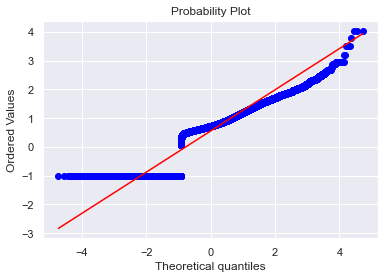

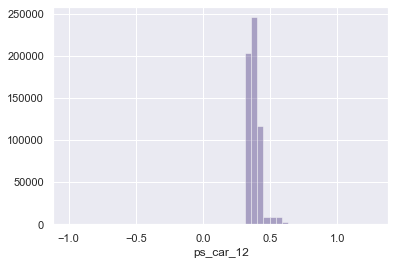

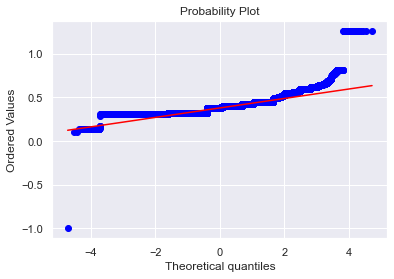

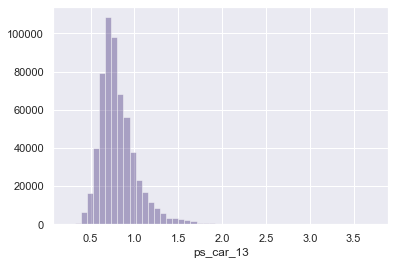

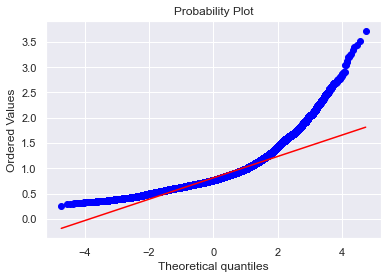

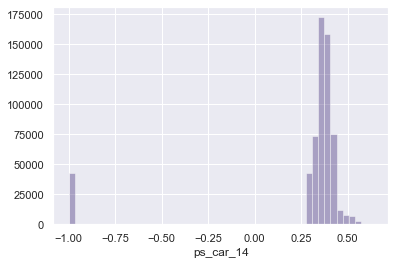

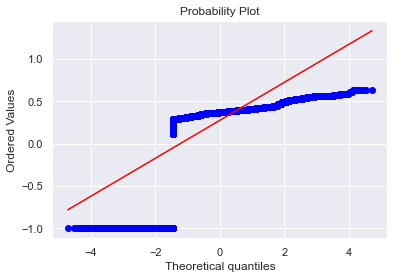

In [60]:
# Распределение количественных переменных
for i in ['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']:
    plt.figure()
    sns.distplot(features[i], kde=False)
    plt.figure()
    stats.probplot(features[i], plot=plt)

In [61]:
# Посмотрим количество категорий во всех признаках кроме бинарных
print('Признак - уникальных категорий')
for i in features.columns:
    print('{} - {}'.format(i, features[i].nunique()))
    print('Категории\n{}'.format(features[i].value_counts()))

# Так же видим, что в "ps_car_03_cat" 4/5 данных - пропуски, а у "ps_car_05_cat" около 50%.

Признак - уникальных категорий
ps_ind_01 - 8
Категории
0    187594
1    143984
2     82468
5     61464
3     51193
4     33524
6     17682
7     17303
Name: ps_ind_01, dtype: int64
ps_ind_02_cat - 5
Категории
 1    431859
 2    123573
 3     28186
 4     11378
-1       216
Name: ps_ind_02_cat, dtype: int64
ps_ind_03 - 12
Категории
2     96110
3     81973
1     67994
4     67213
5     62803
6     60406
7     52364
8     39667
9     25436
0     15514
10    14484
11    11248
Name: ps_ind_03, dtype: int64
ps_ind_04_cat - 3
Категории
 0    346965
 1    248164
-1        83
Name: ps_ind_04_cat, dtype: int64
ps_ind_05_cat - 8
Категории
 0    528009
 6     20662
 4     18344
 1      8322
 3      8233
-1      5809
 2      4184
 5      1649
Name: ps_ind_05_cat, dtype: int64
ps_ind_06_bin - 2
Категории
0    360852
1    234360
Name: ps_ind_06_bin, dtype: int64
ps_ind_07_bin - 2
Категории
0    442223
1    152989
Name: ps_ind_07_bin, dtype: int64
ps_ind_08_bin - 2
Категории
0    497644
1     97568
Na

ps_calc_20_bin - 2
Категории
0    503955
1     91257
Name: ps_calc_20_bin, dtype: int64


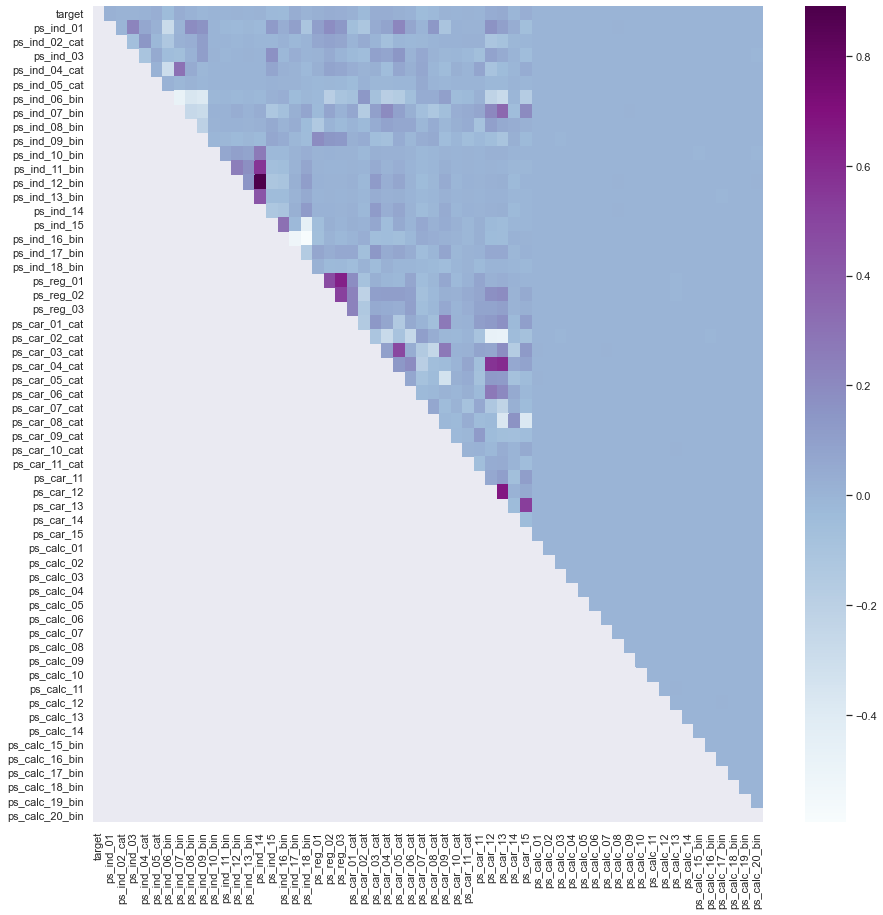

In [62]:
# Коррелционная матрица
corr_matr = np.tril(train.drop('id', axis=1).corr())

# Можем наблюдать странное поведение переменных с корнем "_calc_".
plt.figure(figsize=(15, 15))
sns.heatmap(train.drop('id', axis=1).corr(), cmap='BuPu', mask=corr_matr)

In [63]:
# Посмотрим на признаки с "лучшей" корреляцией с зависимой переменной
correlations = train.corr()['target'].sort_values(ascending=False)

print('Отрицательная корреляция:\n', correlations.tail(15))
print('\nПоложительная корреляция:\n', correlations.head(15))

Отрицательная корреляция:
 ps_calc_13       -0.000446
ps_calc_15_bin   -0.000490
ps_calc_08       -0.001006
ps_calc_20_bin   -0.001072
ps_calc_12       -0.001133
ps_car_11        -0.001213
ps_calc_19_bin   -0.001744
ps_car_14        -0.004474
ps_ind_09_bin    -0.008237
ps_car_08_cat    -0.020342
ps_ind_15        -0.021506
ps_ind_16_bin    -0.027778
ps_car_02_cat    -0.031534
ps_ind_06_bin    -0.034017
ps_car_07_cat    -0.036395
Name: target, dtype: float64

Положительная корреляция:
 target           1.000000
ps_car_13        0.053899
ps_car_12        0.038790
ps_ind_17_bin    0.037053
ps_reg_02        0.034800
ps_ind_07_bin    0.034218
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_reg_03        0.030888
ps_ind_05_cat    0.029165
ps_car_15        0.027667
ps_reg_01        0.022888
ps_car_05_cat    0.020754
ps_ind_01        0.018570
ps_car_01_cat    0.016256
Name: target, dtype: float64


In [64]:
# Посмотрим на значения близкие к нулю и сохраним в список. Так сделаем с несолькими
# способами проверки наших признаков. Затем найдем пересечения этих списков и удалим эти признаки
correlations = pd.DataFrame(correlations)

corr_list_1 = correlations.loc[(-0.01 < correlations.target) & (correlations.target < 0.009)].reset_index()
corr_list_1

,index,target
0,ps_ind_03,0.008360
1,ps_ind_12_bin,0.007810
2,ps_ind_14,0.007443
3,ps_car_11_cat,0.006129
4,ps_car_09_cat,0.005322
5,ps_ind_18_bin,0.004555
6,ps_ind_02_cat,0.004534
7,ps_ind_13_bin,0.002460
8,ps_ind_11_bin,0.002028
9,ps_calc_03,0.001907


In [65]:
# Список признаков. Попали почти все признаки с корнем "_calc_"
del_feature_1 = list(corr_list_1['index'])
del_feature_1

['ps_ind_03',
 'ps_ind_12_bin',
 'ps_ind_14',
 'ps_car_11_cat',
 'ps_car_09_cat',
 'ps_ind_18_bin',
 'ps_ind_02_cat',
 'ps_ind_13_bin',
 'ps_ind_11_bin',
 'ps_calc_03',
 'ps_ind_10_bin',
 'ps_calc_01',
 'ps_calc_14',
 'ps_calc_02',
 'ps_calc_10',
 'ps_car_10_cat',
 'ps_calc_05',
 'ps_calc_09',
 'ps_calc_16_bin',
 'ps_calc_18_bin',
 'ps_calc_11',
 'ps_calc_06',
 'ps_calc_04',
 'ps_calc_07',
 'ps_calc_17_bin',
 'id',
 'ps_calc_13',
 'ps_calc_15_bin',
 'ps_calc_08',
 'ps_calc_20_bin',
 'ps_calc_12',
 'ps_car_11',
 'ps_calc_19_bin',
 'ps_car_14',
 'ps_ind_09_bin']

# Отбор признаков

In [66]:
# Разделим данные и построим первую baseline модель
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.3, stratify=target, random_state=32)

In [67]:
%%time
print('hi')

hi
Wall time: 0 ns


In [68]:
%%time
# Посмотрим на признаки. Но сначала подберем гиперпараметры в три этапа. Первая модель
lgbm = LGBMClassifier(n_estimators=300, random_state=42)

param_grid = {'learning_rate': [0.01, 0.05, 0.1]}

gs = GridSearchCV(lgbm, param_grid=param_grid, cv=6, scoring='roc_auc')
gs.fit(x_train, y_train)

print('Лучший lr: ', gs.best_params_)
print('Лучший результат: ', gs.best_score_)

Лучший lr:  {'learning_rate': 0.05}
Лучший результат:  0.6344169001050333
Wall time: 3min 9s


In [69]:
%%time
# Вторая модель
lgbm_1 = LGBMClassifier(learning_rate=0.05, random_state=42)

param_grid_1 = {'n_estimators': [100, 200, 300]}

gs_1 = GridSearchCV(lgbm_1, param_grid=param_grid_1, cv=6, scoring='roc_auc')
gs_1.fit(x_train, y_train)

print(gs_1.best_params_)
print(gs_1.best_score_)

{'n_estimators': 100}
0.6350957134168916
Wall time: 2min 24s


In [70]:
%%time
lgbm_2 = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)

param_grid_2 = {'max_depth': [5, 10],
                'reg_alpha': [1, 10, 30],
                'bagging_fraction': [0.5, 1],
                'feature_fraction': [0.5, 1]}

gs_2 = GridSearchCV(lgbm, param_grid=param_grid_2, cv=6, scoring='roc_auc')
gs_2.fit(x_train, y_train)

print(gs_2.best_params_)
print(gs_2.best_score_)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, 

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, co

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsampl

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
{'bagging_fraction': 0.5, 'feature_fraction': 0.5, 'max_dept

In [71]:
%%time
# Посмотрим важности признаков на каждой тестовом блоке полного обучающего набора
lgbm_res = LGBMClassifier(n_estimators=100, learning_rate=0.05, bagging_fraction=0.5, 
                          feature_fraction=0.5, max_depth=5, reg_alpha=30, importance_type='gain', random_state=42)

cv = cross_validate(lgbm_res, features, target, cv=6, scoring='roc_auc', return_estimator=True)

cv['test_score'].mean()

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

0.6365959639123128

In [72]:
%%time
train_sizes = np.linspace(.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(LGBMClassifier(n_estimators=100, learning_rate=0.05, bagging_fraction=0.5, 
                          feature_fraction=0.5, max_depth=5, reg_alpha=30, importance_type='gain', random_state=42), x_train, y_train, train_sizes=train_sizes, cv=10, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

Wall time: 7min 46s


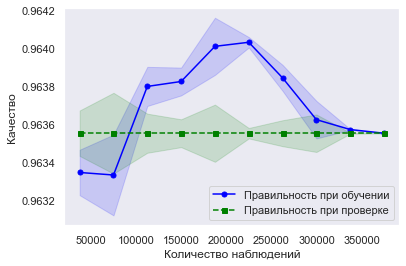

In [73]:
plt.plot(train_sizes, train_scores_mean, color='blue', marker='o', markersize=5, label='Правильность при обучении')
plt.fill_between(train_sizes, 
                 train_scores_mean + train_scores_std,
                 train_scores_mean - train_scores_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_scores_mean, color='green', marker='s', linestyle='--', markersize=5, label='Правильность при проверке')
plt.fill_between(train_sizes, 
                 test_scores_mean + train_scores_std,
                 test_scores_mean - train_scores_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Количество наблюдений')
plt.ylabel('Качество')
plt.legend(loc='lower right')

plt.show()

In [74]:
lgbm_0 = pd.Series(cv['estimator'][0].feature_importances_)
lgbm_1 = pd.Series(cv['estimator'][1].feature_importances_)
lgbm_2 = pd.Series(cv['estimator'][2].feature_importances_)
lgbm_3 = pd.Series(cv['estimator'][3].feature_importances_)
lgbm_4 = pd.Series(cv['estimator'][4].feature_importances_)
lgbm_5 = pd.Series(cv['estimator'][5].feature_importances_)

list_lgbm = [lgbm_0, lgbm_1, lgbm_2, lgbm_3, lgbm_4, lgbm_5]

In [75]:
fi = pd.DataFrame()

for model in list_lgbm:
    fi = fi.append(model, ignore_index=True)

fi.columns = cv['estimator'][0].feature_name_
fi = fi.astype('int')

In [76]:
# Здесь так же видно, что все независимые переменные с корнем _calc_ находятся во второй половине таблицы по важности признака.
new_fi = fi.T
new_fi['mean'] = round(fi.mean(axis=0), 1)
sorted_feat_importance = new_fi.sort_values(by='mean', ascending=False)

In [77]:
sorted_feat_importance

,0,1,2,3,4,5,mean
ps_car_13,8694,9558,9269,9029,9012,9514,9179.3
ps_ind_05_cat,4392,4315,4811,4686,4585,4257,4507.7
ps_ind_17_bin,3970,4033,3569,3520,3675,4072,3806.5
ps_reg_03,3286,3703,4034,3566,3680,3635,3650.7
ps_ind_03,3484,3211,3456,3332,3313,3777,3428.8
ps_car_07_cat,2333,2391,2577,2705,2599,2389,2499.0
ps_ind_06_bin,1984,1860,1977,2121,1904,1686,1922.0
ps_ind_15,1878,1821,1856,1910,1783,2010,1876.3
ps_car_03_cat,2169,1760,1510,1572,1904,1459,1729.0
ps_ind_07_bin,1270,1285,1256,1197,1319,1234,1260.2


In [78]:
# Через корреляцию мы выяснили признаки-кондидаты на удаление и их количество
len(del_feature_1)

35

In [79]:
# Количество признаков датафрейме важностей
new_fi.shape[0]

57

In [80]:
# В важностях признаков возьмем то же количество
sorted_feat_importance[22:]

,0,1,2,3,4,5,mean
ps_car_14,298,212,205,255,149,267,231.0
ps_ind_08_bin,121,174,234,276,259,264,221.3
ps_car_02_cat,215,178,263,195,305,130,214.3
ps_ind_04_cat,167,173,194,226,233,245,206.3
ps_car_11_cat,259,205,194,199,165,165,197.8
ps_calc_14,148,199,188,150,175,186,174.3
ps_calc_10,123,184,137,152,175,168,156.5
ps_car_05_cat,97,118,103,83,114,130,107.5
ps_calc_03,95,77,91,86,69,72,81.7
ps_car_06_cat,75,75,50,47,89,86,70.3


In [81]:
# Второй список признаков-кондидатов на удаление
del_feature_2 = list(sorted_feat_importance.index[22:])
del_feature_2

['ps_car_14',
 'ps_ind_08_bin',
 'ps_car_02_cat',
 'ps_ind_04_cat',
 'ps_car_11_cat',
 'ps_calc_14',
 'ps_calc_10',
 'ps_car_05_cat',
 'ps_calc_03',
 'ps_car_06_cat',
 'ps_calc_11',
 'ps_calc_09',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_12',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_08',
 'ps_calc_04',
 'ps_calc_07',
 'ps_calc_13',
 'ps_car_08_cat',
 'ps_ind_18_bin',
 'ps_calc_15_bin',
 'ps_ind_14',
 'ps_calc_19_bin',
 'ps_calc_20_bin',
 'ps_ind_12_bin',
 'ps_car_10_cat',
 'ps_ind_13_bin',
 'ps_ind_11_bin',
 'ps_ind_10_bin',
 'ps_calc_16_bin',
 'ps_calc_17_bin',
 'ps_calc_18_bin']

In [82]:
%%time
# До этого мы использовали собственные суждения для определения признаков, которые подлежат удалению.
# Теперь обучим модель, с рекурсивным удалением признака.
rfe_cv = RFECV(lgbm_res, cv=6, scoring='roc_auc')
rfe_cv.fit(x_train, y_train)

# Оптимальное количество признаков
rfe_cv.n_features_

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fractio

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
Wall time: 24min 32s


37

In [98]:
# Какие именно признаки следует оставить по мнению алгоритма
rfe_feat = pd.DataFrame(rfe_cv.support_).T
rfe_feat.columns = features.columns

In [33]:
# Последним шагом будет построение модели и проверки, когда и какие признаки начинают включаться в построение дерева.
# Чем раньше, тем важнее признак и наоборот.
m_depth_grid = [1, 2, 3, 4, 5]

fi_md = []

for max_depth in m_depth_grid:
    feat_m_depth = LGBMClassifier(n_estimators=100, learning_rate=0.05, bagging_fraction=0.5, 
                          feature_fraction=0.5, max_depth=max_depth, reg_lambda=10, importance_type='gain', random_state=42)
    
    feat_m_depth.fit(x_train, y_train)
    fi_md.append(feat_m_depth.feature_importances_)

# Добавление номера в имя признака 
fi_md = pd.DataFrame(np.array(fi_md).T, columns=['importance'+str(i) for i in range(len(fi_md))], index=x_train.columns)

fi_md['mean_importance'] = fi_md.mean(axis=1)

fi_md = fi_md.sort_values(by='mean_importance', ascending=False)

fi_md

,importance0,importance1,importance2,importance3,importance4,mean_importance
ps_car_13,7039.137291,8275.255833,8164.589996,8454.616216,8830.576278,8152.835123
ps_ind_05_cat,3325.582710,4073.758400,4519.093361,4841.336708,4862.689130,4324.492062
ps_ind_17_bin,3792.563042,3974.063373,4055.547689,3955.930131,3980.546214,3951.730090
ps_reg_03,2556.969780,3280.544191,3514.469625,3693.413813,4042.212636,3417.522009
ps_ind_03,560.343010,1943.343092,2745.545150,3154.372175,3558.576824,2392.436050
ps_car_07_cat,1997.214981,2193.640304,2183.960183,2257.394153,2357.164646,2197.874853
ps_ind_06_bin,1563.027008,1781.466793,1694.453959,1758.919620,1810.022653,1721.578007
ps_ind_15,463.692001,1060.117897,1383.711637,1633.885065,1985.054365,1305.292193
ps_reg_02,688.829010,902.391308,1112.134096,1431.015541,1662.531080,1159.380207
ps_ind_07_bin,854.346977,1111.760002,1292.124382,1208.906889,1172.263470,1127.880344


### Как вывод: удаляем все переменные с корнем "_calc_"

### Функция предпоготовки данных

In [2]:
# Напишем функцию предварительной подготовки данных. Так как мы будем ансамблировать несколько 
# разных алгоритмов, произведем различную предподготовку.
def preprocessing(data, test_data=False, lightgbm=True):
    # Удаляем переменные '_calc_'
    calc_col = data.columns[data.columns.str.contains('_calc_')]
    data.drop(calc_col, inplace=True, axis=1)
    
    # Так же есть еще нерелевантные признаки.
    data = data.drop(['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 
                      'ps_car_10_cat', 'ps_ind_14', 'ps_ind_18_bin'], axis=1)
    
    # 'id' и целевая переменная
    if test_data:
        test_id = data['id']
        features = data.drop('id', axis=1)
    else:
        data = data.drop('id', axis=1)
        target = data.target
        features = data.drop('target', axis=1)
        
    if lightgbm:        
        # Создаем фрейм категориальных переменных
        cat_col = features.columns[features.columns.str.contains('cat')]
        cat_features = features[cat_col]
        
        # Изменяем тип данных для dummy-кодирования
        for i in cat_col:
            cat_features[i] = cat_features[i].astype('object')    
            
        cat_dummy_features = pd.get_dummies(cat_features)
        
        # Соединяем наши признаки с дамми-переменными
        features = pd.concat([features, cat_dummy_features], axis=1)
        
    if test_data:
        return features, test_id
    else:
        return features, target

In [41]:
# Загружаем данные
train_1 = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\porto-seguro-safe-driver-prediction\\train.csv')
test_1 = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\porto-seguro-safe-driver-prediction\\test.csv')

# Обучение
### LightGBM

In [4]:
features_lgbm, target = preprocessing(train_1, test_data=False, lightgbm=True)

In [5]:
test, identify = preprocessing(test_1, test_data=True, lightgbm=True)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features_lgbm, target, test_size=.3, stratify=target, random_state=31)

### Подбор гиперпараметров
Будем использовать HyperOpt 

In [51]:
def objective(simple_space_lgbm):
    clf = LGBMClassifier(**simple_space_lgbm, n_jobs=-1, random_state=42)
    
    score = cross_val_score(clf, x_train, y_train, scoring='roc_auc', cv=6).mean()
    print(score, simple_space_lgbm)
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -score, 'status': STATUS_OK }


simple_space_lgbm = {
                     'n_estimators': hp.choice('n_estimators', range(100, 1000)),
                     'learning_rate': hp.choice('learning_rate', np.arange(0.01, 0.3, 0.05)),
                     'max_depth': hp.choice('max_depth', np.arange(4, 16, 1, dtype=int)),
                     'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
                     'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
                     'num_leaves': hp.choice('num_leaves', np.arange(2, 31, 1, dtype=int)),
                     'subsample': hp.uniform('subsample', 0.8, 1),
                     'reg_alpha': hp.choice('reg_alpha', np.arange(1, 50, 1, dtype=int)),
                     'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
                     'feature_fraction': hp.uniform('feature_fraction', 0.5, 1)
}


best = fmin(fn=objective,
            space=simple_space_lgbm,
            algo=tpe.suggest,
            max_evals=30)

best

[LightGBM] [Warning] feature_fraction is set=0.626715649572116, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.626715649572116
[LightGBM] [Warning] bagging_fraction is set=0.9403269637060466, subsample=0.8672591601790601 will be ignored. Current value: bagging_fraction=0.9403269637060466
[LightGBM] [Warning] feature_fraction is set=0.626715649572116, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.626715649572116
[LightGBM] [Warning] bagging_fraction is set=0.9403269637060466, subsample=0.8672591601790601 will be ignored. Current value: bagging_fraction=0.9403269637060466
[LightGBM] [Warning] feature_fraction is set=0.626715649572116, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.626715649572116
[LightGBM] [Warning] bagging_fraction is set=0.9403269637060466, subsample=0.8672591601790601 will be ignored. Current value: bagging_fraction=0.9403269637060466
[LightGBM] [Warning] feature_fraction is set=0.62671564957

[LightGBM] [Warning] bagging_fraction is set=0.8553272757276883, subsample=0.9807082879032385 will be ignored. Current value: bagging_fraction=0.8553272757276883
[LightGBM] [Warning] feature_fraction is set=0.8605392488567589, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.8605392488567589
[LightGBM] [Warning] bagging_fraction is set=0.8553272757276883, subsample=0.9807082879032385 will be ignored. Current value: bagging_fraction=0.8553272757276883
[LightGBM] [Warning] feature_fraction is set=0.8605392488567589, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.8605392488567589
[LightGBM] [Warning] bagging_fraction is set=0.8553272757276883, subsample=0.9807082879032385 will be ignored. Current value: bagging_fraction=0.8553272757276883
[LightGBM] [Warning] feature_fraction is set=0.8605392488567589, colsample_bytree=0.6000000000000001 will be ignored. Current value: feature_fraction=0.8605392488567589
[LightG

[LightGBM] [Warning] bagging_fraction is set=0.7492256757254147, subsample=0.9452680975140522 will be ignored. Current value: bagging_fraction=0.7492256757254147
[LightGBM] [Warning] feature_fraction is set=0.6597904758993864, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6597904758993864
[LightGBM] [Warning] bagging_fraction is set=0.7492256757254147, subsample=0.9452680975140522 will be ignored. Current value: bagging_fraction=0.7492256757254147
[LightGBM] [Warning] feature_fraction is set=0.6597904758993864, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6597904758993864
[LightGBM] [Warning] bagging_fraction is set=0.7492256757254147, subsample=0.9452680975140522 will be ignored. Current value: bagging_fraction=0.7492256757254147
[LightGBM] [Warning] feature_fraction is set=0.6597904758993864, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.6597904758993864
[LightGBM] [Warning] bagging_fraction is set=0.74922

[LightGBM] [Warning] bagging_fraction is set=0.9831034197410911, subsample=0.8660490234994848 will be ignored. Current value: bagging_fraction=0.9831034197410911
[LightGBM] [Warning] feature_fraction is set=0.9756288375558586, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9756288375558586
[LightGBM] [Warning] bagging_fraction is set=0.9831034197410911, subsample=0.8660490234994848 will be ignored. Current value: bagging_fraction=0.9831034197410911
0.6259807284114173                                                                                                     
{'bagging_fraction': 0.9831034197410911, 'colsample_bytree': 0.4, 'feature_fraction': 0.9756288375558586, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 219, 'num_leaves': 8, 'reg_alpha': 25, 'subsample': 0.8660490234994848}
[LightGBM] [Warning] feature_fraction is set=0.7084004390685881, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.708400439

[LightGBM] [Warning] bagging_fraction is set=0.5027123996235081, subsample=0.8895721340990634 will be ignored. Current value: bagging_fraction=0.5027123996235081
[LightGBM] [Warning] feature_fraction is set=0.7383670284327969, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.7383670284327969
[LightGBM] [Warning] bagging_fraction is set=0.5027123996235081, subsample=0.8895721340990634 will be ignored. Current value: bagging_fraction=0.5027123996235081
0.6384497798613795                                                                                                     
{'bagging_fraction': 0.5027123996235081, 'colsample_bytree': 0.7000000000000002, 'feature_fraction': 0.7383670284327969, 'learning_rate': 0.060000000000000005, 'max_depth': 12, 'min_child_weight': 4, 'n_estimators': 119, 'num_leaves': 21, 'reg_alpha': 8, 'subsample': 0.8895721340990634}
[LightGBM] [Warning] feature_fraction is set=0.7316431996761685, colsample_bytree=0.700000000000000

{'bagging_fraction': 0.5197558736501999,
 'colsample_bytree': 0,
 'feature_fraction': 0.8005395763311277,
 'learning_rate': 1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 211,
 'num_leaves': 15,
 'reg_alpha': 7,
 'subsample': 0.8716300368763124}

In [52]:
train_sizes = np.linspace(.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
                                            LGBMClassifier(n_estimators=211, num_leaves=15, learning_rate=1,
                                                           min_child_weight=2, subsample=0.8716300368763124, bagging_fraction=0.5197558736501999, 
                                                           feature_fraction=0.8005395763311277, max_depth=4, reg_alpha=7,
                                                           importance_type='gain', colsample_bytree=0, random_state=42), x_train, y_train, train_sizes=train_sizes, cv=10, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

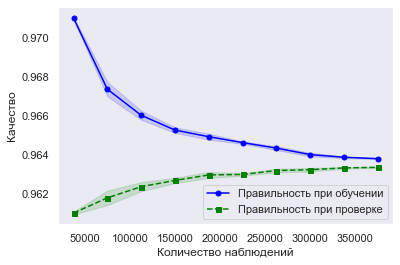

In [53]:
plt.plot(train_sizes, train_scores_mean, color='blue', marker='o', markersize=5, label='Правильность при обучении')
plt.fill_between(train_sizes, 
                 train_scores_mean + train_scores_std,
                 train_scores_mean - train_scores_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_scores_mean, color='green', marker='s', linestyle='--', markersize=5, label='Правильность при проверке')
plt.fill_between(train_sizes, 
                 test_scores_mean + train_scores_std,
                 test_scores_mean - train_scores_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Количество наблюдений')
plt.ylabel('Качество')
plt.legend(loc='lower right')

plt.show()

### XGBoost

In [55]:
features_xgb_cat, target = preprocessing(train_1, test_data=False, lightgbm=False)

In [56]:
test_xgb_cat, identify = preprocessing(test_1, test_data=True, lightgbm=False)

In [58]:
xgb_cat_x_train, xgb_cat_x_test, xgb_cat_y_train, xgb_cat_y_test = train_test_split(features_xgb_cat, target, test_size=0.3, stratify=target)

### Подбор гиперпараметров

In [61]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)

    current_score = cross_val_score(clf, xgb_cat_x_train, xgb_cat_y_train, scoring='roc_auc', cv=6, n_jobs=-1).mean()
    print(current_score, params)
    
    return -current_score


simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
            'eval_metric': 'auc',
            'reg_lambda': hp.quniform('reg_lambda', 1, 50, 5),
            'reg_alpha': hp.quniform('reg_alpha', 0, 50, 5),
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact'
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=30)
print('best:')
print(best)

0.64036874939254                                                                                                       
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 0.55, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 430, 'objective': 'binary:logistic', 'reg_alpha': 15.0, 'reg_lambda': 40.0, 'subsample': 0.7000000000000001, 'tree_method': 'exact'}
0.6346545487564094                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.275, 'eval_metric': 'auc', 'gamma': 0.8, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 936, 'objective': 'binary:logistic', 'reg_alpha': 35.0, 'reg_lambda': 50.0, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
0.6382918217914982                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.17500000

0.6363638604053172                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.05, 'eval_metric': 'auc', 'gamma': 0.8, 'max_depth': 7, 'min_child_weight': 1.0, 'n_estimators': 699, 'objective': 'binary:logistic', 'reg_alpha': 10.0, 'reg_lambda': 45.0, 'subsample': 0.5, 'tree_method': 'exact'}
0.6395735165253814                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.025, 'eval_metric': 'auc', 'gamma': 0.8500000000000001, 'max_depth': 12, 'min_child_weight': 1.0, 'n_estimators': 393, 'objective': 'binary:logistic', 'reg_alpha': 0.0, 'reg_lambda': 50.0, 'subsample': 0.9500000000000001, 'tree_method': 'exact'}
0.6392695178427887                                                                                                     
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta

In [228]:
xgb_res = XGBClassifier(booster='gbtree', 
                        colsample_bytree=0.6000000000000001,
                        eta=0.05,
                        eval_metric='auc',
                        gamma=0.8500000000000001,
                        max_depth=11,
                        min_child_weight=2.0,
                        n_estimators=448,
                        objective='binary:logistic', 
                        reg_alpha=40.0,
                        reg_lambda=0.0,
                        subsample=0.6000000000000001,
                        tree_method='exact')

y_proba_xgb = xgb_res.predict_proba(test_xgb_cat)[:, 1]

# Конечный результат

In [233]:
av_proba = (y_proba_lgbm + y_proba_xgb) / 2

In [234]:
# Сохраняем результат
pd.DataFrame({'id': identify, 'target': av_proba}).to_csv('porto_submission_1.csv', index=False)